# Project 2 Continous Control

### Step 1 : Import nessasry packages

In [2]:
import sys
import random, copy, time
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
%matplotlib inline

# Step2: we will start the environment!

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# step 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Step 4. Take Random Actions in the Environment

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14499999675899744


# Solving environment Using Actor-Critic Model DDGP

# Actor Class
***Its a nural network model takes state as input and outputs action distribution

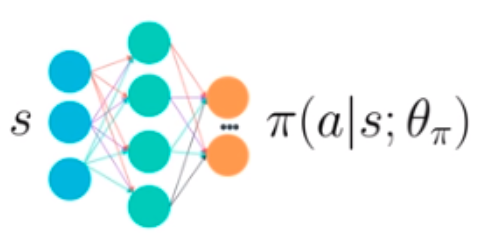

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model. Its a nural network model takes state as input and outputs action distribution"""
    def __init__(self, state_size, action_size, seed, 
                 fc1_units=500, fc2_units=400):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.seed = torch.manual_seed(seed)
        # layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        # initialize network
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_normal_(self.fc1.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc2.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc3.weight.data, nn.init.calculate_gain('tanh'))
    
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.bn1(self.fc1(state)).relu()
        x = self.fc2(x).relu()
        return self.fc3(x).tanh()

# Class Critic

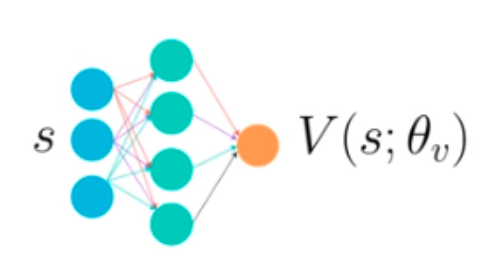

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model. Its a nural network model takes state as input and outputs value for that state
    ***Note how the state and action is passed in the network and mapped to value"""

    def __init__(self, state_size, action_size, seed, 
                 fc1_units=500, fc2_units=400):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        # weight initialization gains 
        self.relu_gain = nn.init.calculate_gain('relu')
        self.linear_gain = nn.init.calculate_gain('linear')
        # layers
        self.fc1 = nn.Linear(state_size, fc1_units)  
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.fc1.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc2.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc3.weight.data, nn.init.calculate_gain('linear'))

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.bn1(self.fc1(state)).relu()
        x = torch.cat((xs, action), dim=1)
        x = self.fc2(x).relu()
        return self.fc3(x)

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + \
             self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",field_names=["state", "action", "reward","next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, states, actions, rewards, next_states, dones):
        """Add a new experience to memory."""
        for i in range(len(states)):
            e = self.experience(states[i], actions[i], rewards[i],next_states[i], dones[i])
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        # Step1 randomly select the experiences
        experiences = random.sample(self.memory, k=self.batch_size)
        # Step2 create a vertical stack of tensor of 
        # all states , actions , rewards , next_states , dones in the experiences and return 
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, random_seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.device = device
        
        #lets define actor network with target network with Adam optimizer
        
        self.actor_local = Actor(state_size, action_size, random_seed).to(self.device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        #lets define critic network with target network with optimizer
        self.critic_local = Critic(state_size, action_size, random_seed).to(self.device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC,weight_decay=WEIGHT_DECAY)
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed,self.device)
        self.noise = OUNoise(action_size, random_seed, sigma=SIGMA)
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to 
           learn."""
        # Save experience / reward
        self.memory.add(states, actions, rewards, next_states, dones)
        
    def sample_and_learn(self):
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    def reset(self):
        self.noise.reset()
        
    def act(self,state,add_noise=True):
        "Return actions for given state as per current policy"
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1.0, 1.0)
    
    def learn(self, experiences, gamma):
        # Lets define states, actions, rewards, next_states, dones as all is part of experiences 
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update critic ---------------------------- #
        # Step 1 send the states in the target actor network and get back action
        actions_next = self.actor_target(next_states)
        # step 2 send this action_next in critic target to get next target value
        Q_targets_next = self.critic_target(next_states, actions_next)
        # step 3 # Compute Q targets for current states
        # Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute Q_expected
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [11]:

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Use CUDA: True


device(type='cuda', index=0)

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
# LR = 5e-4               # learning rate
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # l earning rate of the critic
# UPDATE_EVERY = 4        # how often to update the network
WEIGHT_DECAY = 0        # L2 weight decay
SIGMA = 0.1             # standard deviation for noise

In [13]:
agent = Agent(state_size=state_size, action_size=action_size, 
              random_seed=2, device=device)

In [14]:
def ddpg(n_episodes=1000, max_t=1000, print_every=10):
    acc_scores = []
    acc_scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # get the current state (for each agent)
        states = env_info.vector_observations
        # reset agent
        agent.reset()
        # initialize the score (for each agent)
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            # send all actions to tne environment
            env_info = env.step(actions)[brain_name]
            # get next states, rewards and done flags (for each agent)
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            # agent steps
            agent.step(states, actions, rewards, next_states, dones)
            if t % 20 == 0:
                agent.sample_and_learn()
            states = next_states
            # accumulate rewards
            scores += rewards
            # exit loop if episode finished
            if np.any(dones):
                break

        # save most recent scores
        acc_scores.append(scores)
        acc_scores_window.append(scores)
        
        # model checkpoints
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, 
                                                           np.mean(acc_scores_window)), 
              end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, 
                                                               np.mean(acc_scores_window)))
        if np.mean(acc_scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                  i_episode-100, np.mean(acc_scores_window)))
            break
            
    return acc_scores

tic = time.time()
scores = ddpg()
toc = time.time()
#print("Runtime (in seconds) %d" % int(toc-tic))

Episode 10	Average Score: 0.67
Episode 20	Average Score: 0.49
Episode 30	Average Score: 0.45
Episode 40	Average Score: 0.41
Episode 50	Average Score: 0.37
Episode 60	Average Score: 0.39
Episode 70	Average Score: 0.41
Episode 80	Average Score: 0.52
Episode 90	Average Score: 0.62
Episode 100	Average Score: 0.76
Episode 110	Average Score: 0.85
Episode 120	Average Score: 1.12
Episode 130	Average Score: 1.31
Episode 140	Average Score: 1.68
Episode 150	Average Score: 2.07
Episode 160	Average Score: 2.41
Episode 170	Average Score: 2.83
Episode 180	Average Score: 3.22
Episode 190	Average Score: 3.77
Episode 200	Average Score: 4.33
Episode 210	Average Score: 4.90
Episode 220	Average Score: 5.48
Episode 230	Average Score: 6.17
Episode 240	Average Score: 6.81
Episode 250	Average Score: 7.43
Episode 260	Average Score: 8.25
Episode 270	Average Score: 8.98
Episode 280	Average Score: 9.87
Episode 290	Average Score: 10.80
Episode 300	Average Score: 12.23
Episode 310	Average Score: 14.33
Episode 320	Av

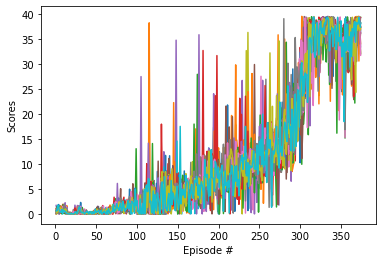

In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

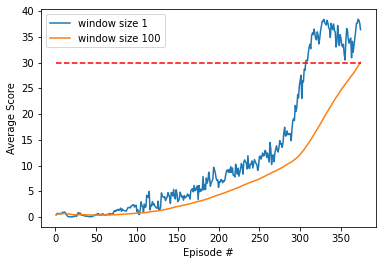

In [16]:
avg_scores = np.array(scores).mean(axis=1)
avg_scores_window = [np.mean(avg_scores[max(0,i-100):i+1]) 
                     for i in range(len(avg_scores))]

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), avg_scores, label="window size 1")
plt.plot(np.arange(1, len(scores)+1), avg_scores_window, label="window size 100")
plt.plot(np.arange(1, len(scores)+1), [30]*len(scores), 
         linestyle='--', color='red')
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [19]:
saved_model_actor = {'state_size': state_size,
                     'action_size': action_size,
                     'fc1_units': 500,
                     'fc2_units': 400,
                     'state_dict': agent.actor_local.state_dict()}

torch.save(saved_model_actor, './models/saved_model_actor.pth')

In [20]:
saved_model_critic = {'state_size': state_size,
                      'action_size': action_size,
                      'fcs1_units': 500,
                      'fc2_units': 400,
                      'state_dict': agent.critic_local.state_dict()}

torch.save(saved_model_critic, './models/saved_model_critic.pth')

In [21]:
env.close()

In [14]:
def load_saved_model_actor(filepath, device):
    saved_model = torch.load(filepath)
    actor = Actor(state_size=saved_model['state_size'], 
                  action_size=saved_model['action_size'], 
                  seed=2,
                  fc1_units=saved_model['fc1_units'],
                  fc2_units=saved_model['fc2_units']).to(device)
    actor.load_state_dict(saved_model['state_dict'])
    
    return actor

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
actor_local = load_saved_model_actor('./models/saved_model_actor.pth', device)
actor_local.eval()

Actor(
  (fc1): Linear(in_features=33, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
agent = Agent(state_size=state_size, action_size=action_size, 
              random_seed=2, device=device)

In [17]:
agent.actor_local = actor_local

In [3]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [18]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.07099914904684


In [ ]:
pip freeze